In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import polars as pl
import utils
from scipy.optimize import least_squares, curve_fit, minimize, differential_evolution
import numpy as np
import os
from tqdm import tqdm
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from DataLoader import DataLoader
import datetime as dt
import statsmodels.api as sm
import joblib as joblib
import Calibration as calibration

import warnings
warnings.filterwarnings("ignore")

In [3]:
start, end = '20060224', '20230831'
loader = DataLoader("./data", "csv")
df = loader.load_dates(start, end, -1).sort('Date')
df = loader.drop_few_strikes(df)

ValueError: cannot concat empty list

In [ ]:
dates = df['Date'].unique().to_list()
expiries = df.unique(['Date', 'Texp']).select(['Date', 'Texp', 'Expiry']).sort(['Date', 'Texp'])

In [ ]:
df

# Calibrate

In [6]:
def model_adjustment(texp: np.ndarray, H: float, eta: float):
    return np.array([
        np.exp(-.125 * calibration.sigma_jim(t, eta, utils.Hurst(H)))
        for t in texp
    ])

In [7]:
def _calibrate_like_a_boss(dd):
    df_day = df.filter(pl.col('Date') == dd)
    texp = df_day['Texp'].unique().sort().to_numpy()
    expiries = df_day['Expiry'].unique().sort().to_list()
    if len(texp) < 5:
        return {'H': np.nan, 'eta': np.nan, 'err_code': 1}, np.inf
    
    # get VIX Futures price (put-call parity)
    vix_f = df_day.unique(
        subset=['Expiry']
    ).sort('Texp').select(
        ['Texp', 'Fwd']
    ).to_pandas().set_index('Texp').squeeze()

    # compute constant strip
    exp_zeta = pd.Series({
        t: calibration.vix_power(df_day.to_pandas(), t_int, 2)
        for t, t_int in zip(texp, expiries)
    })

    # need this function in here becauase it uses `exp_zeta`
    def model_fair_value(texp: np.ndarray, H: float, eta: float):
        adj = model_adjustment(texp, H, eta)
        return (exp_zeta**.5) * adj
    
    try:
        loss_fun = lambda x: np.sum((vix_f.values - model_fair_value(texp, *x).values) ** 2)
        # params, _ = curve_fit(
        #     model_fair_value, texp, vix_f.values,
        #     bounds=[(0, 0), (1, np.inf)]
        # )
        opt = differential_evolution(
            loss_fun, x0=np.array([0.07, 1.9]),
            bounds=((0., 1.), (0., 1000.)),
            # options=options
        )
        if opt.success:
            params = opt.x
            loss = opt.fun
        else:
            return {'H': np.nan, 'eta': np.nan, 'err_code': 2}, np.nan
    except RuntimeError:
        return {'H': np.nan, 'eta': np.nan, 'err_code': 2}
    return dict(zip(['H', 'eta', 'err_code'], np.concatenate((params, [0])))), loss

def calibrate_like_a_boss(dd):
    try:
        return _calibrate_like_a_boss(dd)
    except Exception as e:
        return {'H': np.nan, 'eta': np.nan, 'err_code': 3}, np.nan

In [ ]:
out = joblib.Parallel(n_jobs=-1)(
    joblib.delayed(_calibrate_like_a_boss)(dd) for dd in dates
)

params = [x[0] for x in out]
loss = [x[1] for x in out]

In [19]:
params = pd.DataFrame(params, index=dates)
params.to_parquet(f"params_futures_diffevo_{start}_{end}.parquet")

In [20]:
loss = pd.Series(loss, index=dates)

In [21]:
params.describe()

,H,eta,err_code
count,4366.000000,4366.000000,4409.000000
mean,0.080138,6.549565,0.009753
std,0.078812,11.842068,0.098285
min,0.000002,0.920649,0.000000
25%,0.008938,1.498485,0.000000
50%,0.062901,1.977299,0.000000
75%,0.134494,4.442452,0.000000
max,1.000000,268.574377,1.000000


In [8]:
params = pd.read_parquet(f"params_futures_diffevo_{start}_{end}.parquet")

In [9]:
(params['H'] > .6).sum()

2

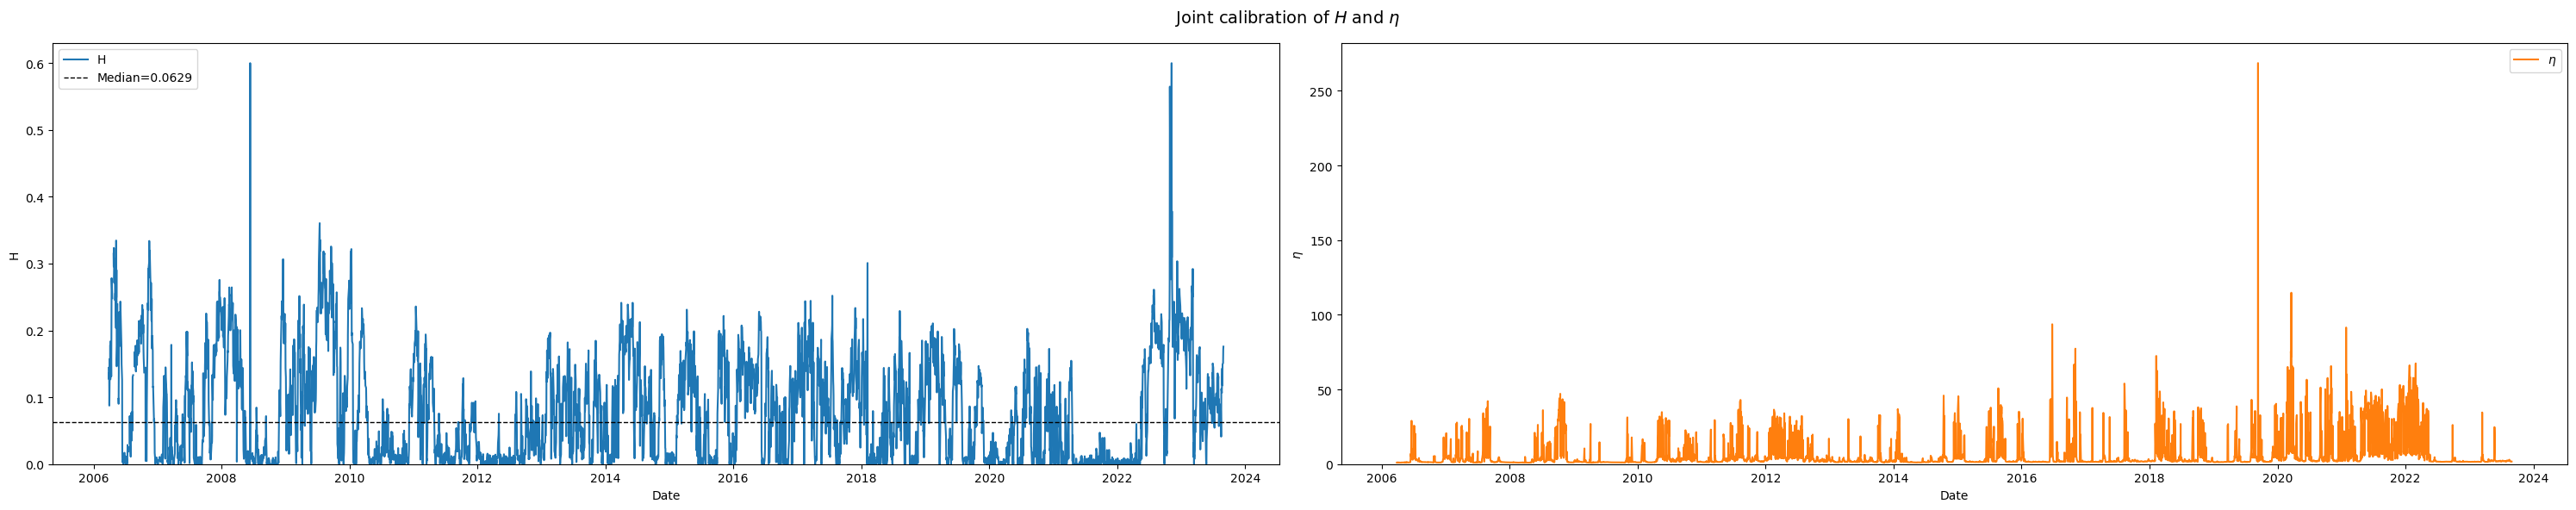

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(30, 6))
fig.suptitle(r"Joint calibration of $H$ and $\eta$", fontsize=14)

axs[0].plot(params['H'].clip(0, .6), label='H', color='C0')
axs[0].axhline(params['H'].median(), ls='--', color='black', lw=1, label=f'Median={params["H"].median():.4f}')
axs[1].plot(params['eta'], label=r'$\eta$', color='C1')
axs[0].set_ylabel("H"); axs[1].set_ylabel(r"$\eta$")
for ax in axs:
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylim(bottom=0)
    # ax.fill_between(params.index, *ax.get_ylim(), where=params['err_code'], alpha=.5, facecolor='grey', label='Fails')
    ax.vlines(params.index[params['err_code'] == 2], *ax.get_ylim(), color='gray', label='Fails')

fig.tight_layout()
# plt.savefig(f"./Plots/futures_lbfgs_params_{start}_{end}.png")
plt.show()

In [16]:
params_plot = params[['H']].clip(0., .6)
params_plot['alpha'] = params_plot['H'] - 0.5

window, center = 100, False
params_plot['H_smooth'] = params_plot['H'].rolling(window, center=center).mean()
params_plot['alpha_smooth'] = params_plot['alpha'].rolling(window, center=center).mean()
params_plot = params_plot.dropna()

In [17]:
risks = {
    'Lehman bankruptcy': dt.date(2008, 9, 15),
    'Greek Debt': dt.date(2012, 12, 1),
    'COVID': dt.date(2020, 2, 15),
    'Russia invasion': dt.date(2022, 2, 24)
}

markers = 'v<^>'

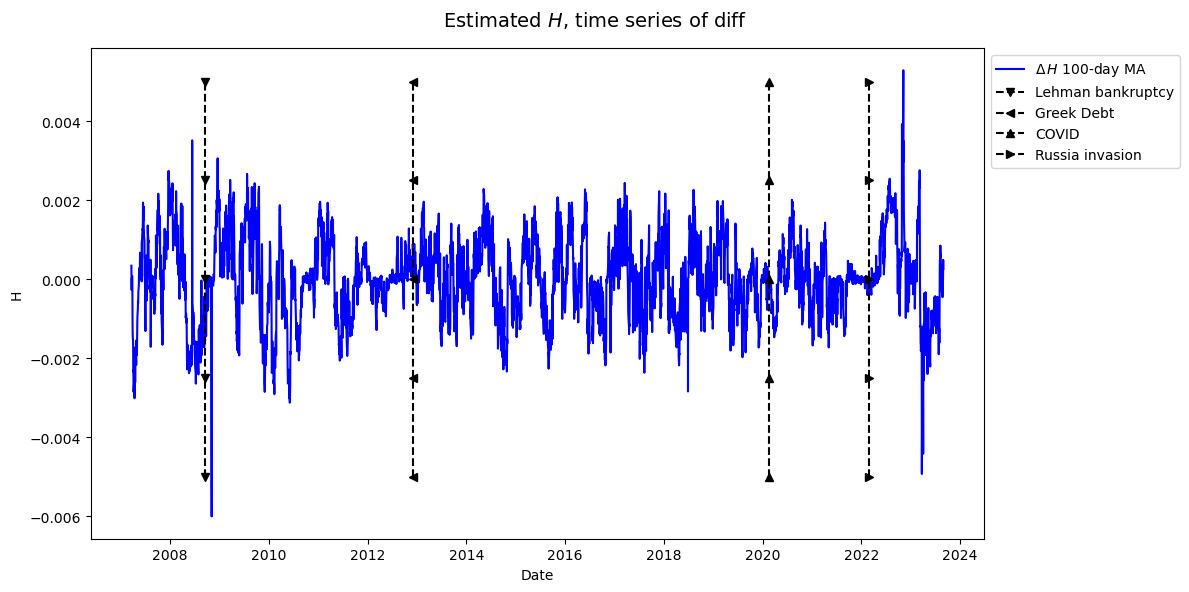

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
fig.suptitle(r"Estimated $H$, time series of diff", fontsize=14)

# ax.plot(params_plot['H'].clip(0, .6).diff(), label=r'$\Delta\,H$', color='limegreen')
ax.plot(params_plot['H_smooth'].diff(), label=f'$\Delta\,H$ {window}-day MA', color='blue')
for i, (name, dd) in enumerate(risks.items()):
    ax.plot([dd]*5, np.linspace(-.005, .005, 5), ls='--', color='black', label=name, marker=markers[i])

ax.set_ylabel("H")
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel("Date")

fig.tight_layout()
plt.show()

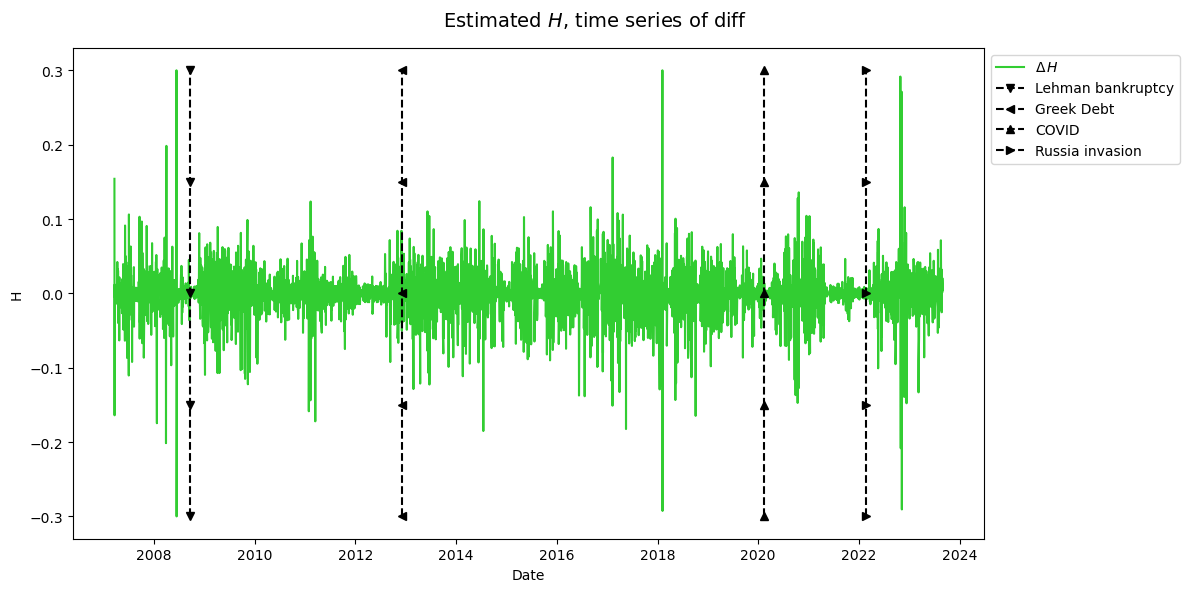

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
fig.suptitle(r"Estimated $H$, time series of diff", fontsize=14)

ax.plot(params_plot['H'].diff().clip(-.3, .3), label=r'$\Delta\,H$', color='limegreen')
for i, (name, dd) in enumerate(risks.items()):
    ax.plot([dd]*5, np.linspace(-.3, .3, 5), ls='--', color='black', label=name, marker=markers[i])

ax.set_ylabel("H")
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel("Date")

fig.tight_layout()
plt.show()

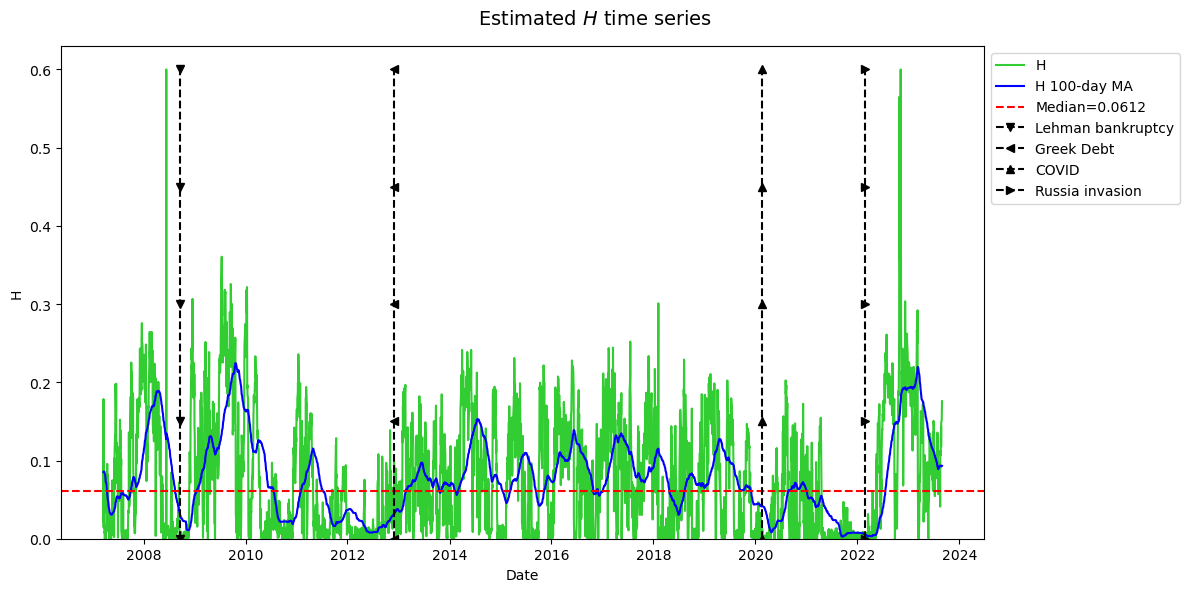

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
fig.suptitle(r"Estimated $H$ time series", fontsize=14)

ax.plot(params_plot['H'].clip(0, .6), label='H', color='limegreen')
ax.plot(params_plot['H_smooth'].clip(0, .6), label=f'H {window}-day MA', color='blue')
ax.axhline(params_plot['H'].median(), ls='--', color='red',
           label=f'Median={params_plot["H"].median():.4f}')
for i, (name, dd) in enumerate(risks.items()):
    ax.plot([dd]*5, np.linspace(0., .6, 5), ls='--', color='black', label=name, marker=markers[i])

ax.set_ylabel("H")
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel("Date")
ax.set_ylim(bottom=0)

fig.tight_layout()
plt.savefig(f"./Plots/futures_h_timeseries_{start}_{end}.png")
plt.show()

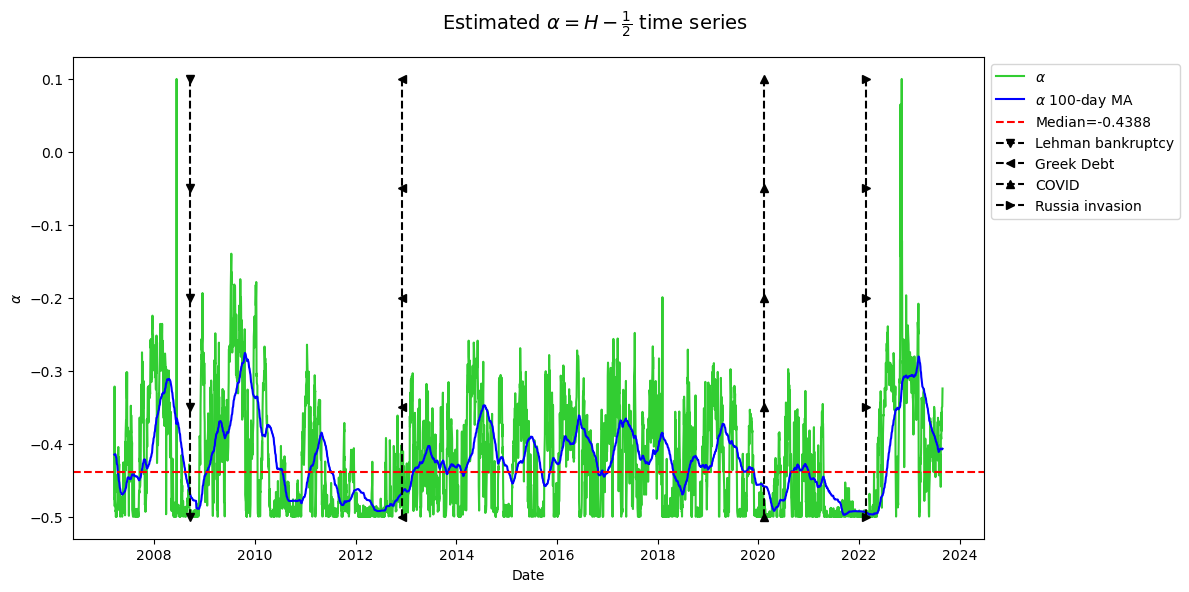

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
fig.suptitle(r"Estimated $\alpha = H - \frac{1}{2}$ time series", fontsize=14)

ax.plot(params_plot['alpha'].clip(-.5, .1), label=r'$\alpha$', color='limegreen')
ax.plot(params_plot['alpha_smooth'].clip(-.5, .1), label=f'$\\alpha$ {window}-day MA', color='blue')
ax.axhline(params_plot['alpha'].median(), ls='--', color='red',
           label=f'Median={params_plot["alpha"].median():.4f}')
for i, (name, dd) in enumerate(risks.items()):
    ax.plot([dd]*5, np.linspace(-.5, .1, 5), ls='--', color='black', label=name, marker=markers[i])

ax.set_ylabel(r"$\alpha$")
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel("Date")
# ax.set_xticks(np.arange(len(params_plot.index.year.unique()))); ax.set_xticklabels(params_plot.index.year.unique())
fig.tight_layout()
# plt.savefig(f"./Plots/futures_h_timeseries_{start}_{end}.png")
plt.show()

In [42]:
import yfinance as yf

In [43]:
vxx = yf.download('VXX')

[*********************100%***********************]  1 of 1 completed


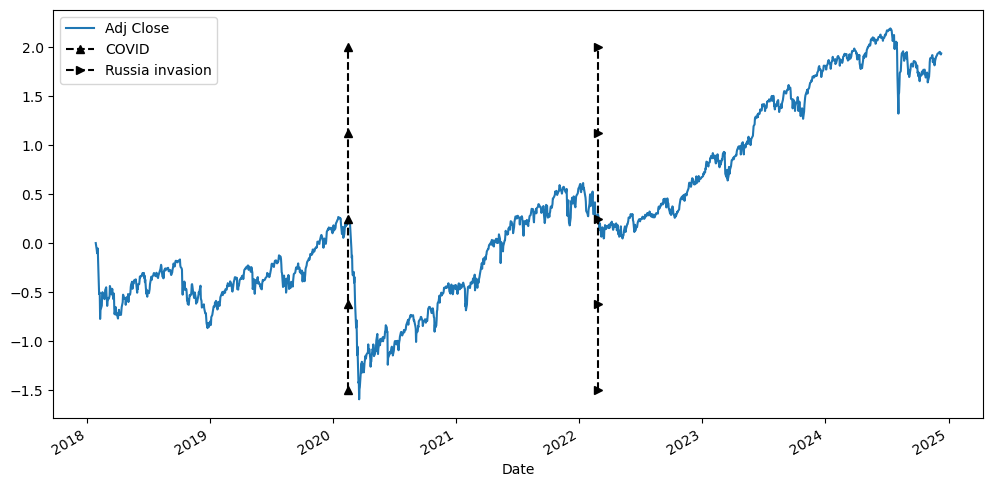

In [62]:
ax = (-(vxx['Adj Close'].pct_change())).cumsum().plot(figsize=(12, 6))
for i, (name, dd) in enumerate(risks.items()):
    if dd < vxx.index[0].date():
        continue
    ax.plot([dd]*5, np.linspace(-1.5, 2.0, 5), ls='--', color='black', label=name, marker=markers[i])
ax.legend()
plt.show()

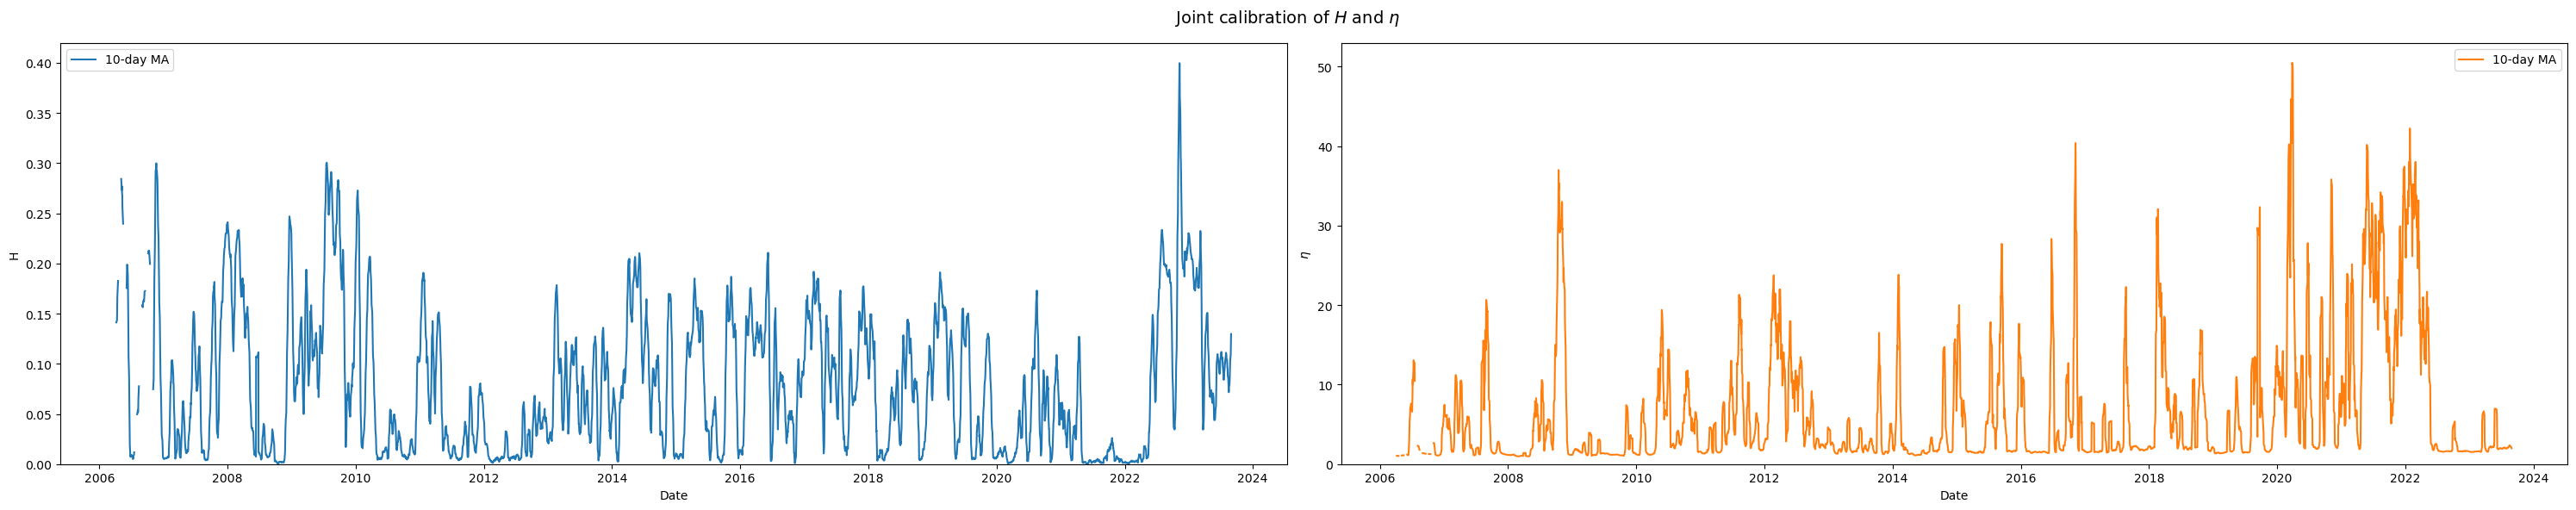

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(30, 6))
fig.suptitle(r"Joint calibration of $H$ and $\eta$", fontsize=14)

axs[0].plot(params['H'].rolling(10).mean(), label='10-day MA', color='C0')
axs[1].plot(params['eta'].rolling(10).mean(), label='10-day MA', color='C1')
axs[0].set_ylabel("H"); axs[1].set_ylabel(r"$\eta$")
for ax in axs:
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylim(bottom=0)

fig.tight_layout()
plt.show()

In [24]:
params['err_code'].value_counts() / params.shape[0]

err_code
0.0    0.990247
1.0    0.009753
Name: count, dtype: float64

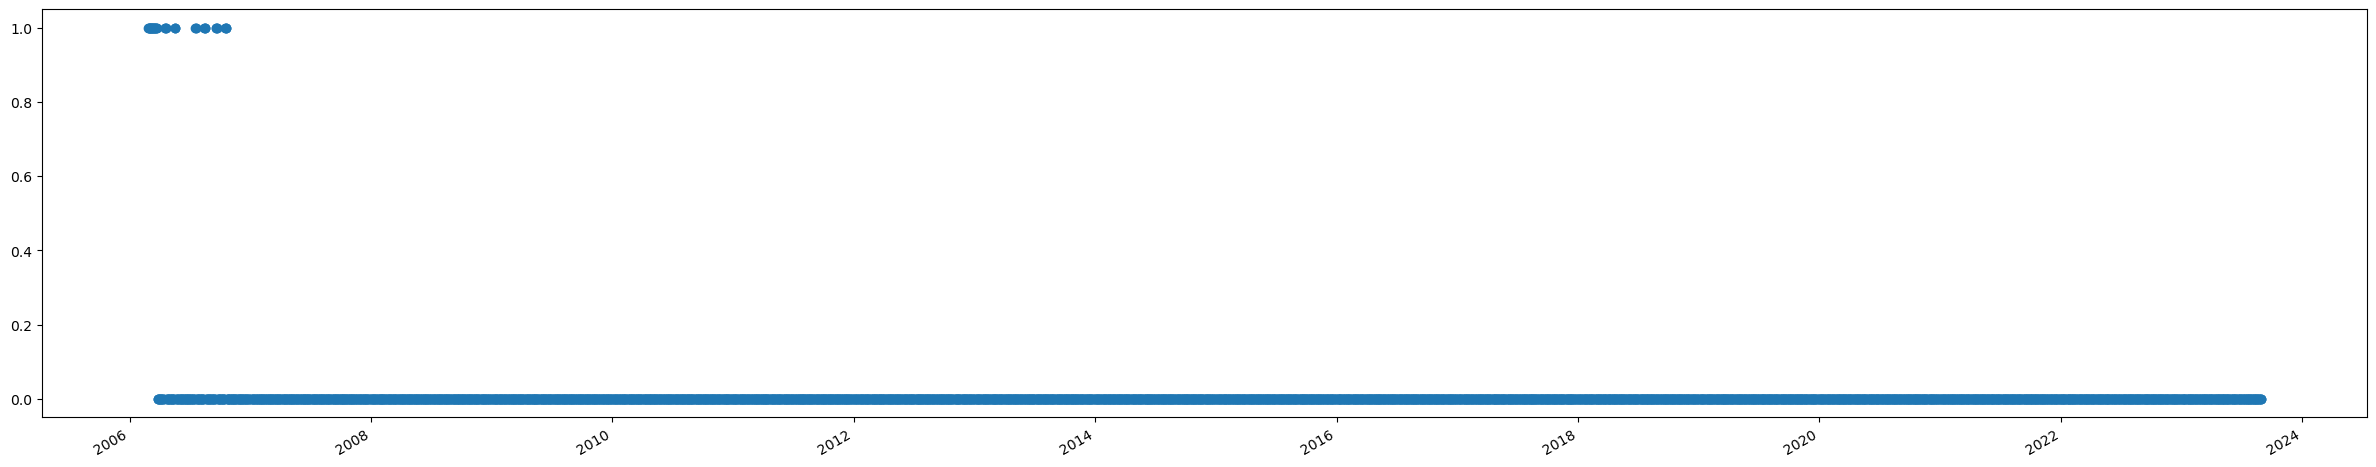

In [25]:
params['err_code'].plot(figsize=(30, 6) ,lw=0, marker='o')
plt.show()

In [26]:
params.corr()

,H,eta,err_code
H,1.000000,-0.424799,NaN
eta,-0.424799,1.000000,NaN
err_code,NaN,NaN,1.0


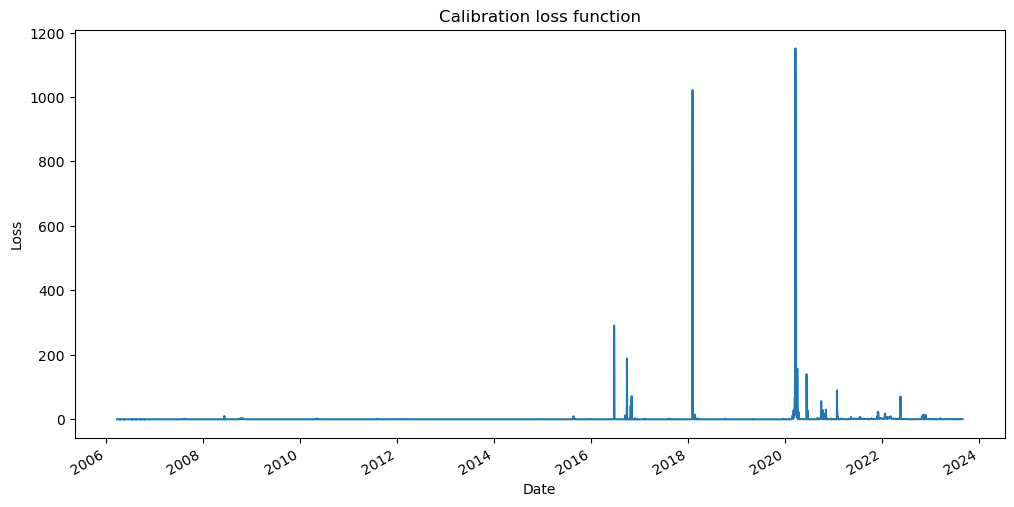

In [27]:
loss.plot(figsize=(12, 6))
plt.title("Calibration loss function"); plt.ylabel("Loss"); plt.xlabel("Date")
plt.show()

In [41]:
loss.to_frame().to_parquet(f"futures_loss_diffevo.parquet")

# Draw curves on random days

In [53]:
params = pl.from_pandas(params.rename_axis("Date"), include_index=True).drop('err_code').drop_nulls()

In [54]:
df = df.join(params, on='Date', how='inner')

In [55]:
df

Expiry,Texp,Strike,k,Bid,Ask,Fwd,CallMid,Date,H,eta
i64,f64,f64,f64,f64,f64,f64,f64,datetime[ns],f64,f64
20060419,0.0629,12.5,0.008734,0.611649,0.652438,12.391306,0.725,2006-03-27 00:00:00,0.144169,1.017627
20060419,0.0629,15.0,0.191055,0.678319,0.915322,12.391306,0.25,2006-03-27 00:00:00,0.144169,1.017627
20060517,0.139612,10.0,-0.263296,0.454556,0.600988,13.012116,3.05,2006-03-27 00:00:00,0.144169,1.017627
20060517,0.139612,12.5,-0.040152,0.522551,0.576943,13.012116,1.325,2006-03-27 00:00:00,0.144169,1.017627
20060517,0.139612,15.0,0.142169,0.662419,0.747276,13.012116,0.675,2006-03-27 00:00:00,0.144169,1.017627
…,…,…,…,…,…,…,…,…,…,…
20240522,0.728268,110.0,1.68999,0.899486,0.960186,20.297357,0.213034,2023-08-30 00:00:00,0.175862,1.715023
20240522,0.728268,120.0,1.777001,0.917649,0.977613,20.297357,0.187055,2023-08-30 00:00:00,0.175862,1.715023
20240522,0.728268,130.0,1.857044,0.930241,0.996458,20.297357,0.166271,2023-08-30 00:00:00,0.175862,1.715023


In [56]:
def model_fair_value(exp_zeta: pd.Series, texp: np.ndarray, H: float, eta: float):
    adj = model_adjustment(texp, H, eta)
    return (exp_zeta**.5) * adj

In [66]:
def plot_curve(dd: dt.date, ax):
    df_day = df.filter(pl.col('Date') == dd)
    texp = df_day['Texp'].unique().sort().to_numpy()
    expiries = df_day['Expiry'].unique().sort().to_list()

    vix_f = df_day.unique(
        subset=['Expiry']
    ).sort('Texp').select(
        ['Texp', 'Fwd']
    ).to_pandas().set_index('Texp').squeeze()

    exp_zeta = pd.Series({
        t: calibration.vix_power(df_day.to_pandas(), t_int, 2)
        for t, t_int in zip(texp, expiries)
    })

    h, eta = df_day[['H', 'eta']].unique()
    h, eta = h.item(), eta.item()
    fair_value = model_fair_value(exp_zeta, texp, h, eta)

    ax.plot(texp, vix_f, lw=0, marker='X', color='red', label='Market Price')
    ax.plot(texp, fair_value, ls=':', marker='.', label=f'Model Fit: H={h:.4f}, $\eta$={eta:.2f}')
    ax.set_title(f"{dd.strftime('%Y-%m-%d')}"); ax.set_ylabel("Vix Futures")
    ax.set_xlabel("T [years]")
    ax.legend()

In [64]:
dates = df['Date'].unique().to_list()

np.random.seed(12)
sub_dates = np.concatenate((
    [dt.datetime(2015, 12, 4), dt.datetime(2016, 2, 22), dt.datetime(2016, 1, 4),],
    np.random.choice(dates, 12)
))
sub_dates.sort()

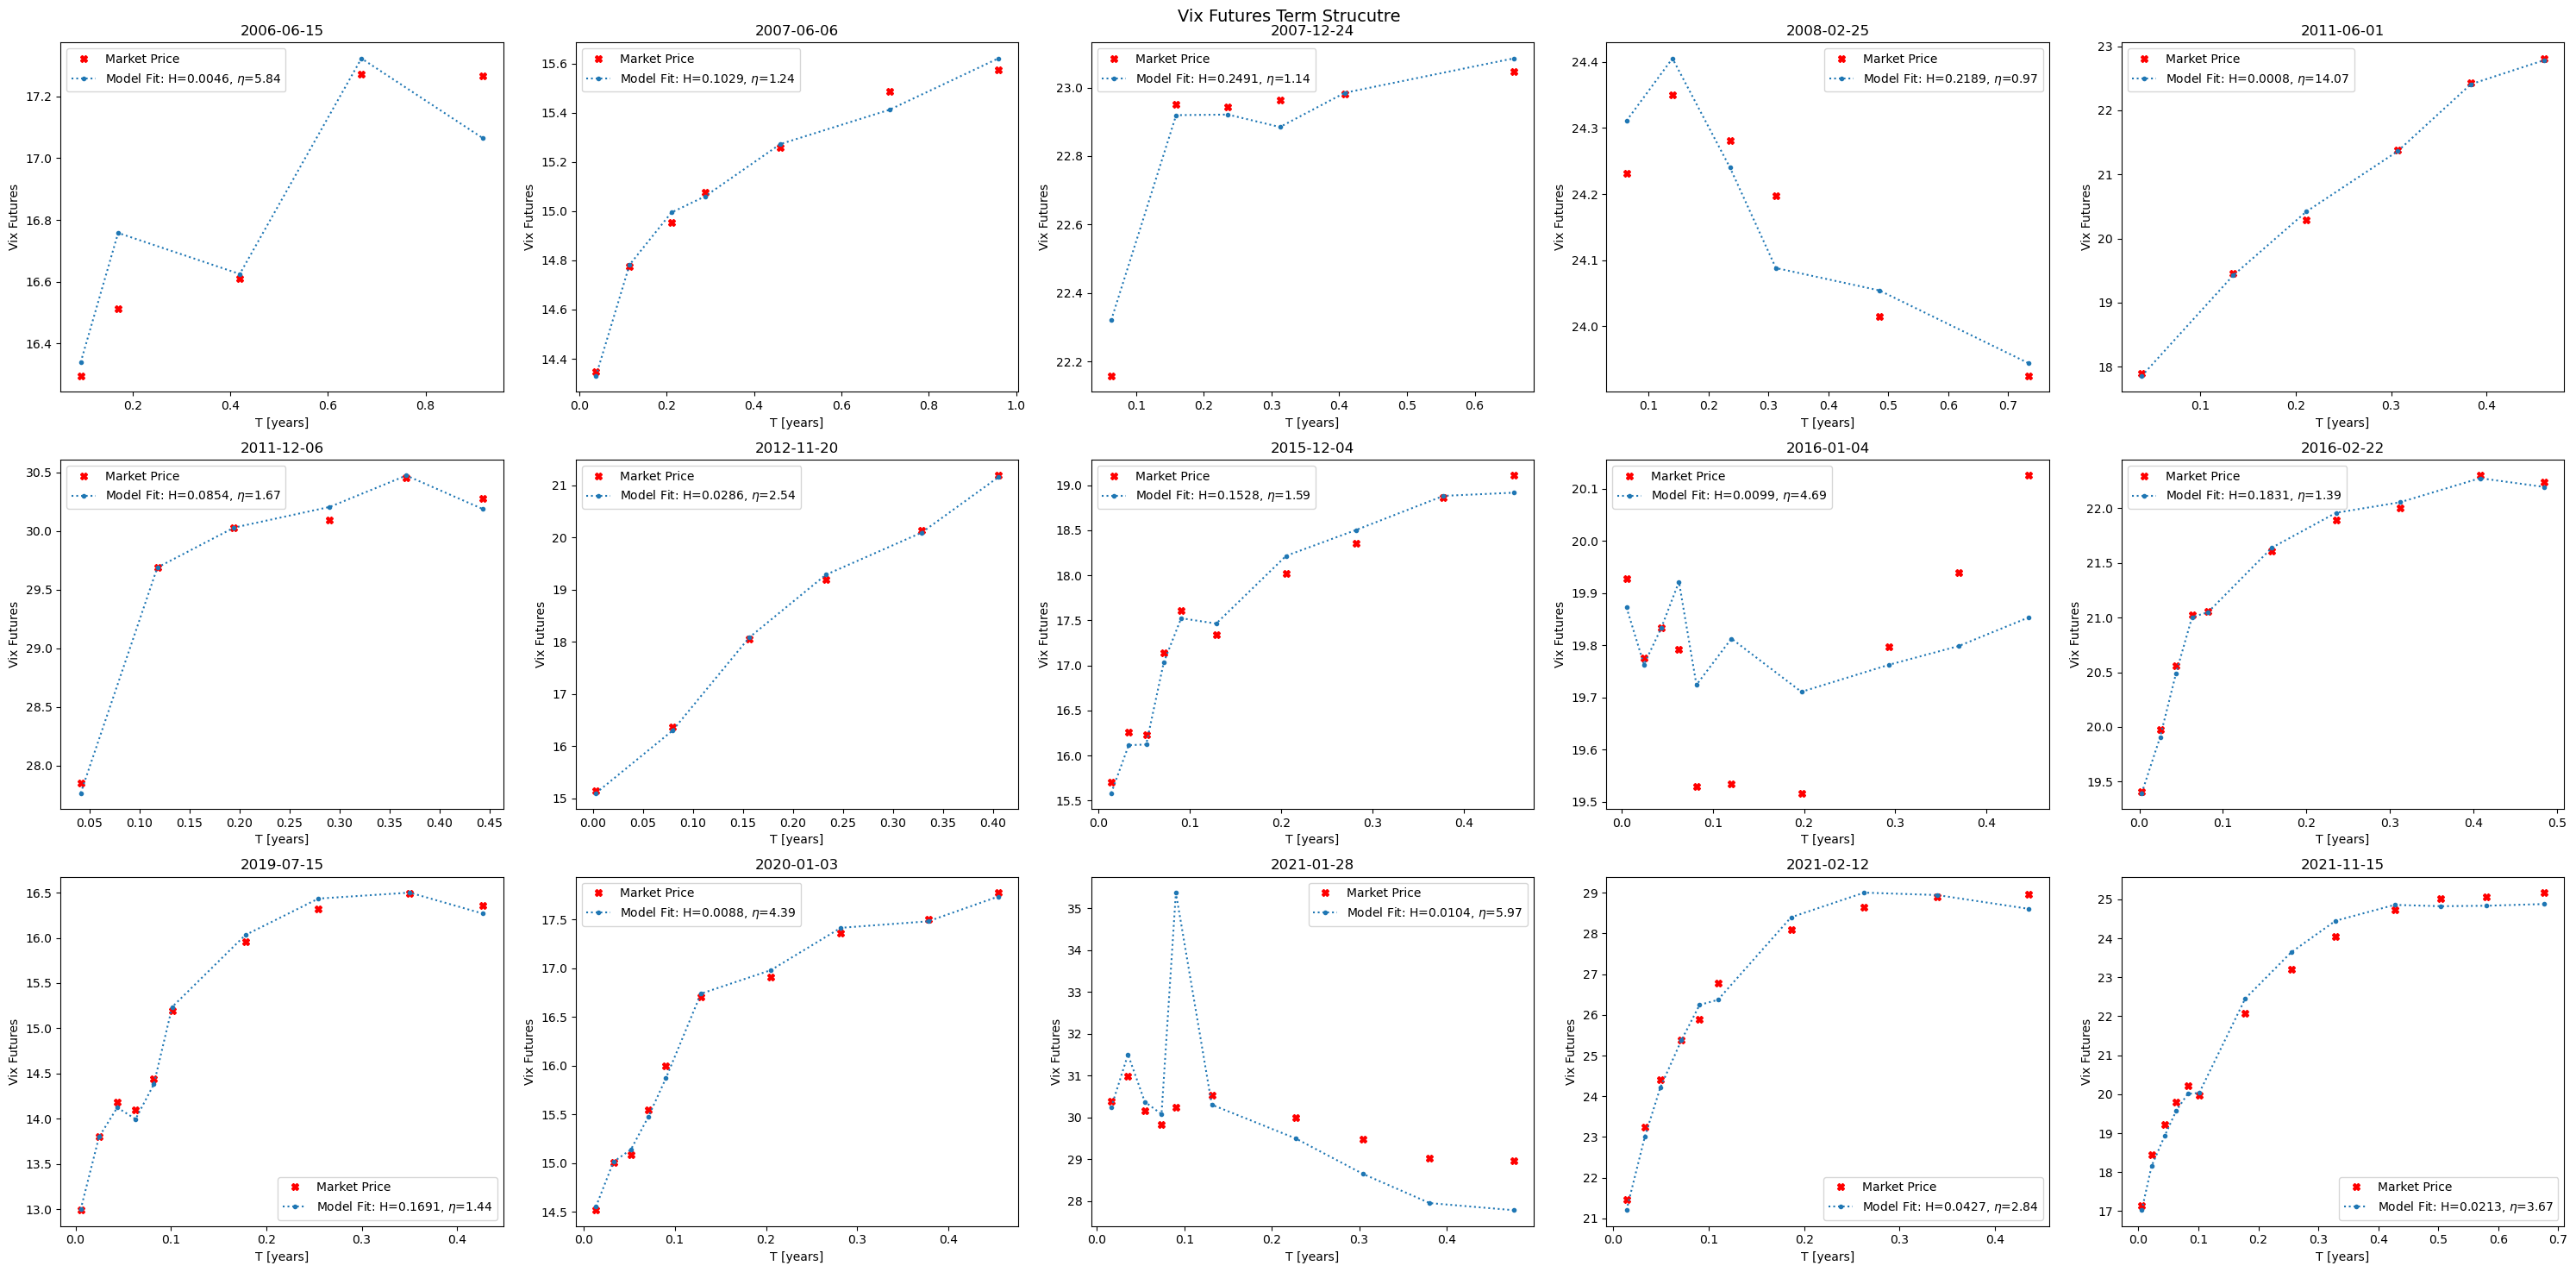

In [67]:
fig, axs = plt.subplots(3, 5, figsize=(30, 15))
axs = axs.flatten()
fig.suptitle("Vix Futures Term Strucutre", fontsize=14)

for i, dd in enumerate(sub_dates):
    plot_curve(dd, axs[i])

fig.tight_layout()
plt.show()

In [37]:
def calibration_jim(texps, h, _eta):
    hurst = utils.Hurst(h)
    sigma_model = np.array([
        calibration.sigma_jim(texp, _eta, hurst) for texp in texps
    ])
    return sigma_model
    
def plot_variance_curve(dd: dt.date, ax):
    df_day = df.filter(pl.col('Date') == dd)
    texp = df_day['Texp'].unique().sort().to_numpy()
    expiries = df_day['Expiry'].unique().sort().to_list()

    sigma = np.array([
        calibration.sigma_market(df_day.to_pandas().set_index('Date'), exp) for exp in expiries
    ])

    h, eta = df_day[['H', 'eta']].unique()
    h, eta = h.item(), eta.item()
    sigma_fit = calibration_jim(texp, h, eta)

    ax.plot(texp, sigma, lw=0, marker='X', color='red', label='Strip Estimation')
    ax.plot(texp, sigma_fit, ls=':', marker='.', label=f'Model Fit: H={h:.4f}, $\eta$={eta:.2f}')
    ax.set_title(f"{dd.strftime('%Y-%m-%d')}"); ax.set_ylabel(r"$\sigma^2$")
    ax.set_xlabel("T [years]")
    ax.legend()

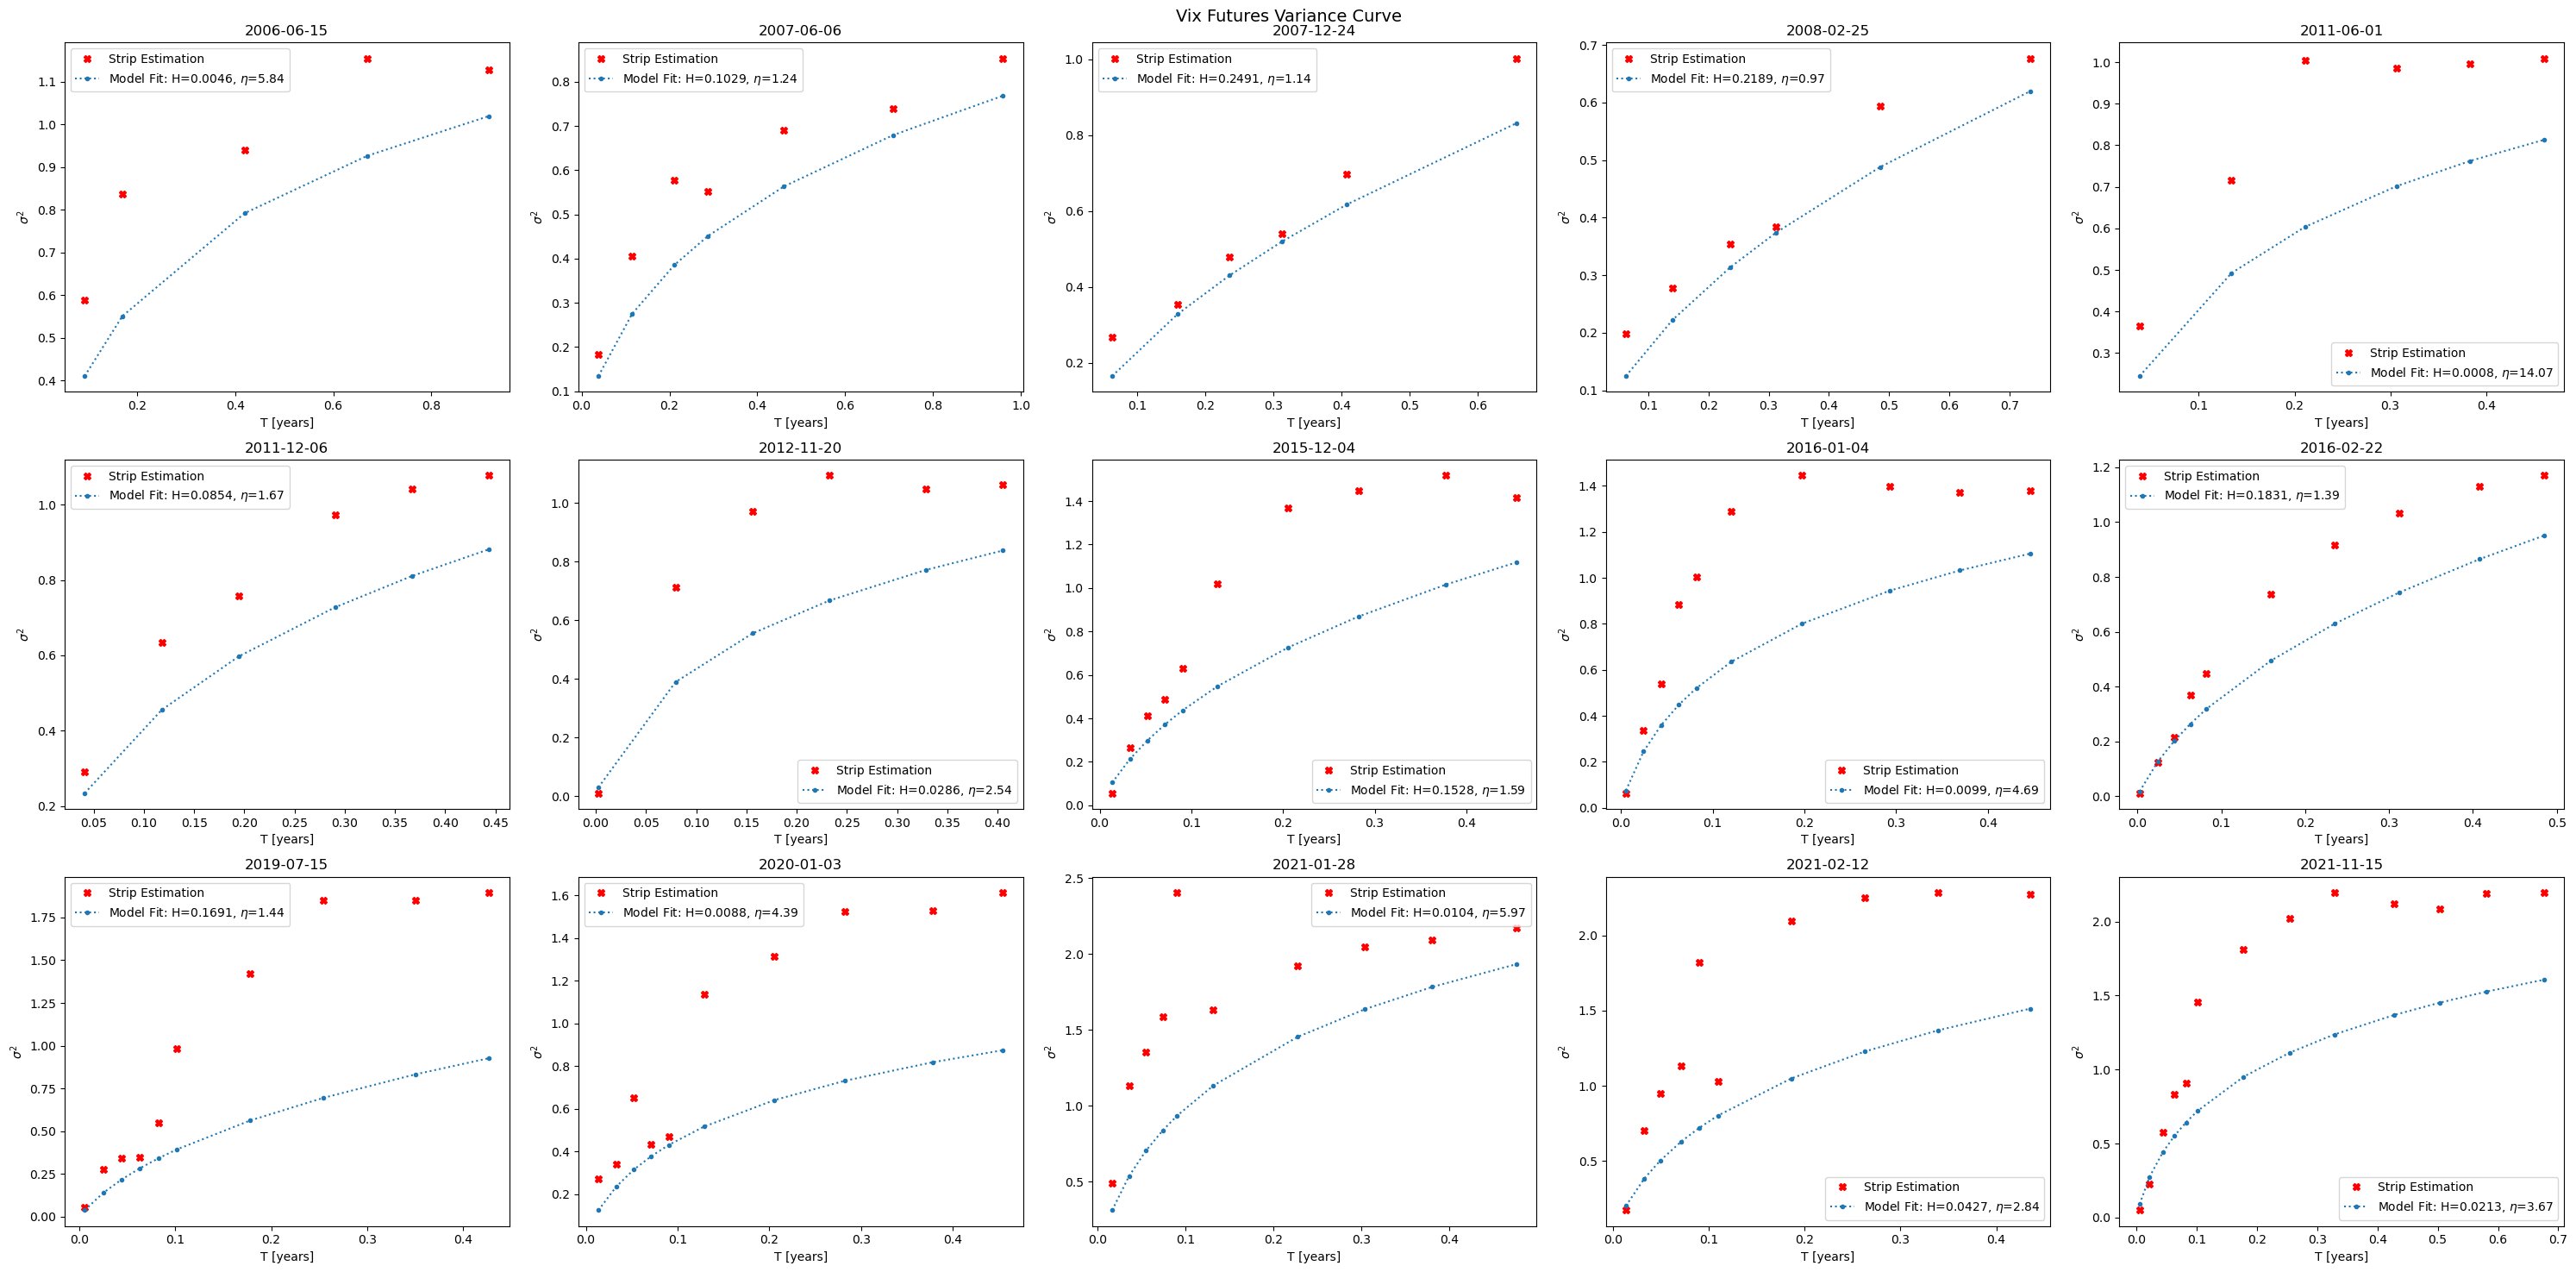

In [38]:
fig, axs = plt.subplots(3, 5, figsize=(30, 15))
axs = axs.flatten()
fig.suptitle("Vix Futures Variance Curve", fontsize=14)

for i, dd in enumerate(sub_dates):
    plot_variance_curve(dd, axs[i])

fig.tight_layout()
plt.show()

In [37]:
df

Expiry,Texp,Strike,k,Bid,Ask,Fwd,CallMid,Date
i64,f64,f64,f64,f64,f64,f64,f64,datetime[ns]
20060322,0.071233,12.5,0.020056,0.397999,0.751937,12.251797,0.625,2006-02-24 00:00:00
20060322,0.071233,15.0,0.202378,0.500455,0.667055,12.251797,0.1,2006-02-24 00:00:00
20060419,0.147831,12.5,-0.038988,0.346001,0.533366,12.99698,1.3,2006-02-24 00:00:00
20060419,0.147831,15.0,0.143333,0.46873,0.758272,12.99698,0.55,2006-02-24 00:00:00
20060419,0.147831,17.5,0.297484,0.590799,1.052294,12.99698,0.475,2006-02-24 00:00:00
…,…,…,…,…,…,…,…,…
20240522,0.728268,110.0,1.68999,0.899486,0.960186,20.297357,0.213034,2023-08-30 00:00:00
20240522,0.728268,120.0,1.777001,0.917649,0.977613,20.297357,0.187055,2023-08-30 00:00:00
20240522,0.728268,130.0,1.857044,0.930241,0.996458,20.297357,0.166271,2023-08-30 00:00:00


In [ ]:
7/252

0.027777777777777776

In [ ]:
21/252

0.08333333333333333

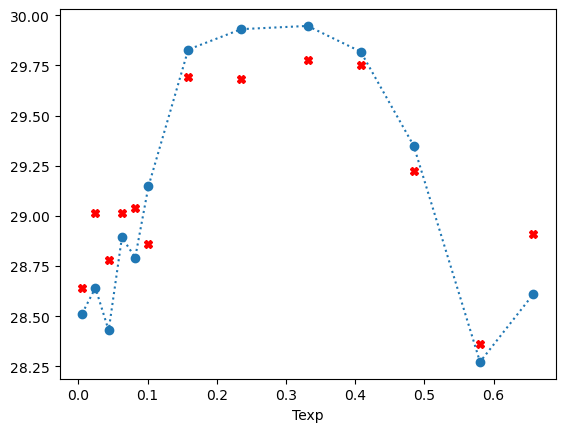

In [ ]:
vix_f.plot(lw=0, marker='X', color='red')
fair_value.plot(ls=':', marker='o')
plt.show()

# Debug

Everything fixed now! :)

### Error code 3: index error

In [ ]:
params[params['err_code'] == 3].shape

(25, 3)

In [ ]:
err3_dates = params.loc[params['err_code'] == 3].index
err3_dates = [d.to_pydatetime().date() for d in err3_dates]

In [ ]:
err3 = pl.DataFrame(err3_dates).with_columns(
    Date=pl.col('column_0').cast(pl.Datetime('ns'))
).drop('column_0').join(
    df, on='Date', how='left'
)

In [ ]:
sum([df.filter(pl.col('Date') == d).shape[0] for d in err3_dates]) == err3.shape[0]

True

In [ ]:
err3.group_by(['Date', 'Texp'], maintain_order=True).agg(
    pl.col('Strike').len()
).group_by('Date').agg(pl.col('Strike').min()).describe()

statistic,Date,Strike
str,str,f64
"""count""","""25""",25.0
"""null_count""","""0""",0.0
"""mean""","""2012-02-10 00:57:36""",1.0
"""std""",null,0.0
"""min""","""2006-08-15 00:00:00""",1.0
"""25%""","""2007-05-15 00:00:00""",1.0
"""50%""","""2010-12-21 00:00:00""",1.0
"""75%""","""2016-05-03 00:00:00""",1.0
"""max""","""2018-01-02 00:00:00""",1.0


##### $\therefore$ Need to drop observations with less than 2 strikes

### Error code 1: not enough amturities

In [ ]:
params[params['err_code'] == 1].shape[0] / params.shape[0]

0.009299160807439328

Threshold of 5 drops only $< 1\%$ of days - good enough.

### Error code 2: optimization fail

In [ ]:
err2_dates = params.loc[params['err_code'] == 2].index
err2_dates = [d.to_pydatetime().date() for d in err2_dates]

err2 = pl.DataFrame(err2_dates).with_columns(
    Date=pl.col('column_0').cast(pl.Datetime('ns'))
).drop('column_0').join(
    df, on='Date', how='left'
)

In [ ]:
len(err2_dates) / params.shape[0]

0.018598321614878656

In [ ]:
n_texp_fail = err2.group_by('Date').agg(pl.col('Texp').unique().len())
n_texp_fail.describe()

statistic,Date,Texp
str,str,f64
"""count""","""82""",82.0
"""null_count""","""0""",0.0
"""mean""","""2016-01-10 12:00:00""",8.731707
"""std""",null,2.699103
"""min""","""2007-01-03 00:00:00""",5.0
"""25%""","""2012-03-07 00:00:00""",6.0
"""50%""","""2016-09-19 00:00:00""",9.0
"""75%""","""2020-03-24 00:00:00""",10.0
"""max""","""2022-03-11 00:00:00""",13.0


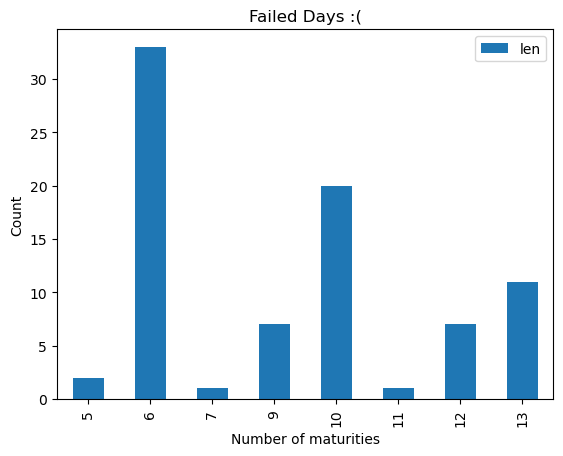

In [ ]:
n_texp_fail.group_by('Texp').len().to_pandas().set_index('Texp').sort_index().plot.bar()
plt.xlabel("Number of maturities"); plt.ylabel("Count"); plt.title("Failed Days :(")
plt.show()

#### Un giorno solo

In [ ]:
sub = df.filter(pl.col('Date') == err2_dates[6])

In [ ]:
sub

Expiry,Texp,Strike,k,Bid,Ask,Fwd,CallMid,Date
i64,f64,f64,f64,f64,f64,f64,f64,datetime[ns]
20081119,0.060388,26.0,-0.731317,1.319578,1.456989,54.023183,28.05,2008-10-28 00:00:00
20081119,0.060388,28.0,-0.657209,1.19668,1.413132,54.023183,25.9,2008-10-28 00:00:00
20081119,0.060388,30.0,-0.588216,1.198,1.348462,54.023183,24.0,2008-10-28 00:00:00
20081119,0.060388,32.5,-0.508173,1.187738,1.33059,54.023183,21.65,2008-10-28 00:00:00
20081119,0.060388,35.0,-0.434065,1.236649,1.32891,54.023183,19.45,2008-10-28 00:00:00
…,…,…,…,…,…,…,…,…
20090415,0.463014,60.0,0.517266,0.643587,0.720615,35.7689,1.4,2008-10-28 00:00:00
20090415,0.463014,65.0,0.597308,0.640771,0.731046,35.7689,1.05,2008-10-28 00:00:00
20090415,0.463014,70.0,0.671416,0.623621,0.73395,35.7689,0.75,2008-10-28 00:00:00


In [ ]:
texp = sub['Texp'].unique().sort().to_numpy()
exp_int = sub['Expiry'].unique().sort().to_numpy()
print(len(texp))

6


In [ ]:
vix_f = sub.unique(
    subset=['Expiry']
).sort('Texp').select(
    ['Texp', 'Fwd']
).to_pandas().set_index('Texp').squeeze()

In [ ]:
exp_zeta = pd.Series({
    t: calibration.vix_power(sub.to_pandas(), t_int, 2)
    for t, t_int in zip(texp, exp_int)
})

In [ ]:
exp_zeta

0.060388    3342.710324
0.137100    2253.521888
0.232991    1923.297766
0.309703    1752.609730
0.386301    1607.277333
0.463014    1574.126758
dtype: float64

In [ ]:
def model_fair_value(texp: np.ndarray, H: float, eta: float):
    adj = model_adjustment(texp, H, eta)
    return (exp_zeta**.5) * adj

0.060388    55.310906
0.137100    44.189405
0.232991    39.929646
0.309703    37.614499
0.386301    35.629350
0.463014    34.931080
dtype: float64

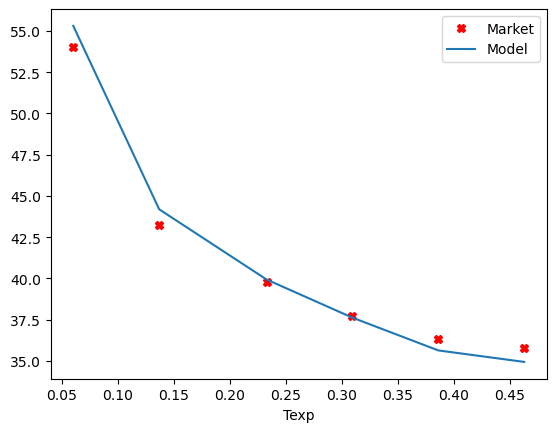

In [ ]:
vix_f.plot(lw=0, marker='X', color='red', label='Market')
model_fair_value(texp, .07, 1.9).plot(label='Model')
plt.legend()
plt.show()

In [ ]:
loss = lambda x: np.sum((vix_f.values - model_fair_value(texp, *x).values) ** 2)

In [ ]:
loss([.07, 1.9])

3.70656802616452

In [ ]:
opt = minimize(
    loss, x0=np.array([.07, 1.9]),
    method='L-BFGS-B',
    options={'maxls': 50},
    bounds=((0., 1.), (0., np.inf))
)

In [ ]:
opt.message

'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [ ]:
loss(opt.x)

2.4933451340543296

In [ ]:
opt.x

array([8.87067371e-05, 4.54084856e+01])

In [ ]:
def calculate_loss_like_a_loss(dd):
    try:
        df_day = df.filter(pl.col('Date') == dd)
        texp = df_day['Texp'].unique().sort().to_numpy()
        expiries = df_day['Expiry'].unique().sort().to_list()
        if len(texp) < 5:
            return {'H': np.nan, 'eta': np.nan, 'err_code': 1}
        
        # get VIX Futures price (put-call parity)
        vix_f = df_day.unique(
            subset=['Expiry']
        ).sort('Texp').select(
            ['Texp', 'Fwd']
        ).to_pandas().set_index('Texp').squeeze()

        # compute constant strip
        exp_zeta = pd.Series({
            t: calibration.vix_power(df_day.to_pandas(), t_int, 2)
            for t, t_int in zip(texp, expiries)
        })

        # need this function in here becauase it uses `exp_zeta`
        def model_fair_value(texp: np.ndarray, H: float, eta: float):
            adj = model_adjustment(texp, H, eta)
            return (exp_zeta**.5) * adj
        
        x = params.loc[dd, ['H', 'eta']]
        return np.sum((vix_f.values - model_fair_value(texp, *x).values) ** 2)
    except Exception as d:
        return np.nan



In [ ]:
out = joblib.Parallel(n_jobs=-1)(
    joblib.delayed(calculate_loss_like_a_loss)(dd) for dd in dates
)

/Users/niccolofabbri/Desktop/CLASSES/Capstone_BergomiVIX/Calibration.py:71: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  callIntegral, _ = quad(
/Users/niccolofabbri/Desktop/CLASSES/Capstone_BergomiVIX/Calibration.py:71: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  callIntegral, _ = quad(
/Users/niccolofabbri/Desktop/CLASSES/Capstone_BergomiVIX/Calibration.py:71: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing th

KeyboardInterrupt: 

In [ ]:
out

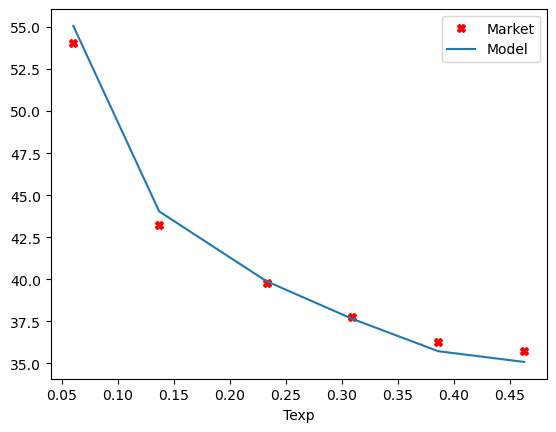

In [ ]:
vix_f.plot(lw=0, marker='X', color='red', label='Market')
model_fair_value(texp, *opt.x).plot(label='Model')
plt.legend()
plt.show()

In [ ]:
_calibrate_like_a_boss(err2_dates[6])

{'H': nan, 'eta': nan, 'err_code': 2}

In [ ]:
params.loc[~params['err_code'].isin([0.0, 1, 2]), 'err_code'] = 3

In [ ]:
params.isna().sum()

In [ ]:
params.describe()

In [ ]:
out = [
    calibrate_like_a_boss(dt.date(2023, 4, 14)),
    calibrate_like_a_boss(dt.date(2023, 4, 17)),
    calibrate_like_a_boss(dt.date(2023, 4, 18))
]

In [ ]:
pd.DataFrame(out)

,H,eta
0,0.170998,1.532215
1,0.175126,1.538961
2,0.135746,1.642663


In [ ]:
df.filter(pl.col('Date') == dt.date(2023, 4, 18))

Expiry,Texp,Strike,k,Bid,Ask,Fwd,CallMid,Date
i64,f64,f64,f64,f64,f64,f64,f64,datetime[ns]
20230426,0.021903,16.0,-0.116218,0.556948,0.690351,17.971844,2.052016,2023-04-18 00:00:00
20230426,0.021903,17.0,-0.055593,0.563833,0.714366,17.971844,1.257456,2023-04-18 00:00:00
20230426,0.021903,18.0,0.001565,0.645702,0.796929,17.971844,0.751611,2023-04-18 00:00:00
20230426,0.021903,19.0,0.055633,0.848956,0.929496,17.971844,0.54116,2023-04-18 00:00:00
20230426,0.021903,20.0,0.106926,0.88627,0.947488,17.971844,0.315676,2023-04-18 00:00:00
…,…,…,…,…,…,…,…,…
20231220,0.673511,110.0,1.532315,0.834245,0.907078,23.763845,0.203762,2023-04-18 00:00:00
20231220,0.673511,120.0,1.619326,0.843624,0.927436,23.763845,0.172414,2023-04-18 00:00:00
20231220,0.673511,130.0,1.699369,0.854613,0.941858,23.763845,0.14629,2023-04-18 00:00:00


# TODO:

* Time series of $H$ and $\eta$
* Fit $\tilde{\eta}$ instead of $\eta$ (need to break up $f^H$);
* Compare model and S\&P skew
* Match ATM vols

In [ ]:
daily random barter
